# 1. Code lại code trong file thực hành 

## Import thư viện 

In [1]:
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from numpy import random
from pandas import DataFrame
from sklearn.cluster import KMeans
import seaborn as sns

## Chuẩn bị dữ liệu 

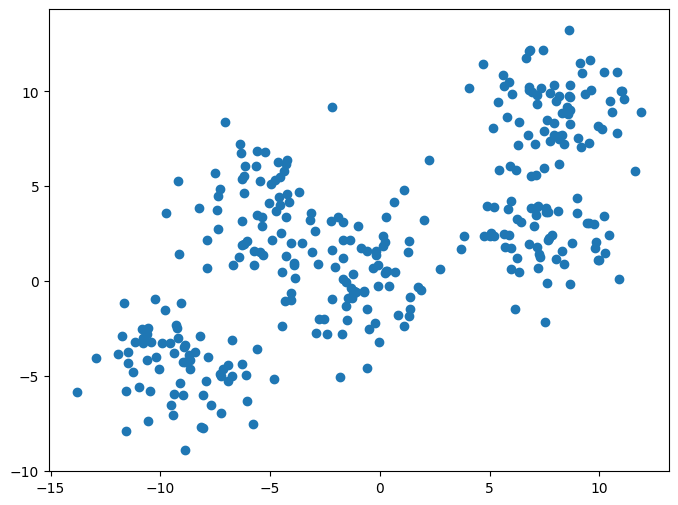

In [2]:
random.seed(234)
x,y=make_blobs(n_samples=330, centers=5,cluster_std=1.84)
plt.figure(figsize=(8,6))
plt.scatter(x[:,0],x[:,1])
plt.show()

## Xây dựng mô hình GMM với số cụm là 5

In [3]:
gm= GaussianMixture(n_components=5).fit(x)
centers=gm.means_
print(centers)

[[-5.55839384  3.87288254]
 [ 7.28633633  2.54355009]
 [-9.1828898  -4.4785241 ]
 [ 8.10880025  9.23182354]
 [-0.90236602  0.16316915]]


## Vẽ các tâm và các điểm dữ liệu 

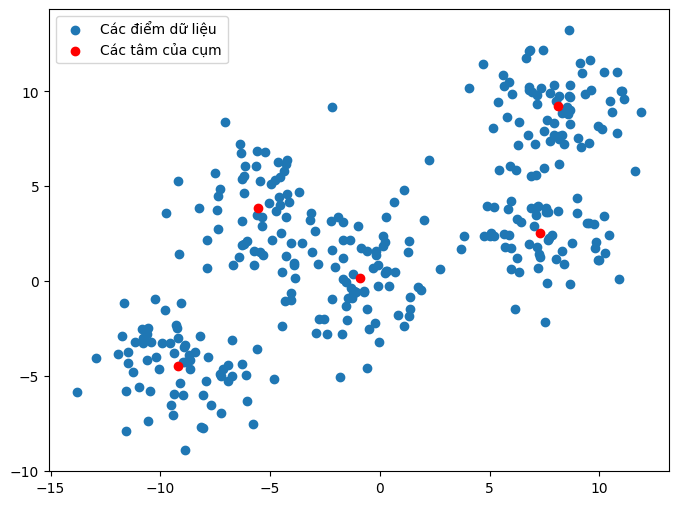

In [4]:
plt.figure(figsize=(8,6))
plt.scatter(x[:,0],x[:,1],label="Các điểm dữ liệu")
plt.scatter(centers[:,0],centers[:,1],c='r',label="Các tâm của cụm")
plt.legend()
plt.show()

## Dự đoán với mô hình GMM, trực quan hóa  

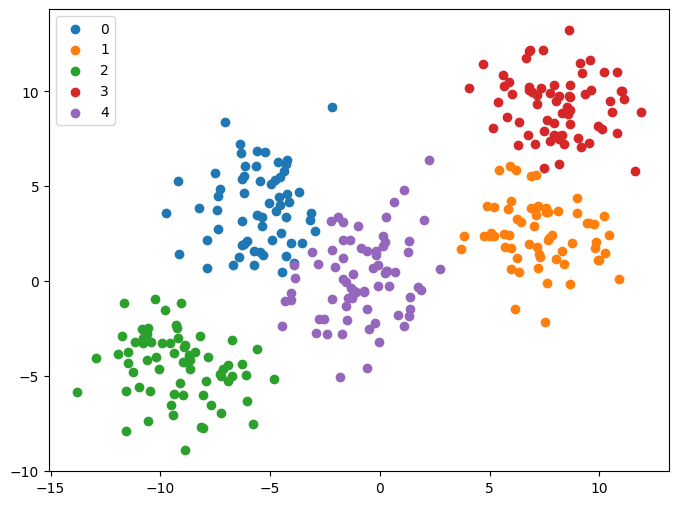

In [5]:
pred=gm.predict(x)
df=DataFrame({'x':x[:,0],'y':x[:,1],'label':pred})
groups=df.groupby('label')

fig,ax=plt.subplots(figsize=(8,6))
for name, group in groups:
    ax.scatter(group.x,group.y,label=name)

ax.legend()
plt.show()

## Thay đổi số cụm và vẽ trên cùng đồ thị

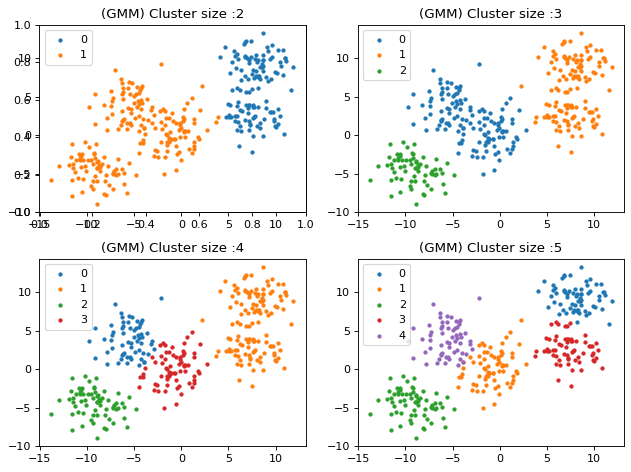

In [6]:
fig = plt.figure(figsize=(8,6),dpi=80)
fig.add_subplot(2,2,1)

for i in range(2,6):
    gm=GaussianMixture(n_components=i).fit(x)
    pred=gm.predict(x)
    df=DataFrame({'x':x[:,0],'y':x[:,1],'label':pred})
    groups=df.groupby('label')
    fig.add_subplot(2,2,i-1)
    for name,group in groups:
        plt.scatter(group.x,group.y,label=name,s=8)
        plt.title("(GMM) Cluster size :" + str(i))
        plt.legend()

plt.tight_layout()
plt.show()

## Gọm cụm sử dụng Kmeans

c:\Users\votua\AppData\Local\Programs\Virtual Enviroment Python\ENV\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\votua\AppData\Local\Programs\Virtual Enviroment Python\ENV\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\votua\AppData\Local\Programs\Virtual Enviroment Python\ENV\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\votua\AppData\Local\Programs\Virtual Enviroment Python\ENV\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` 

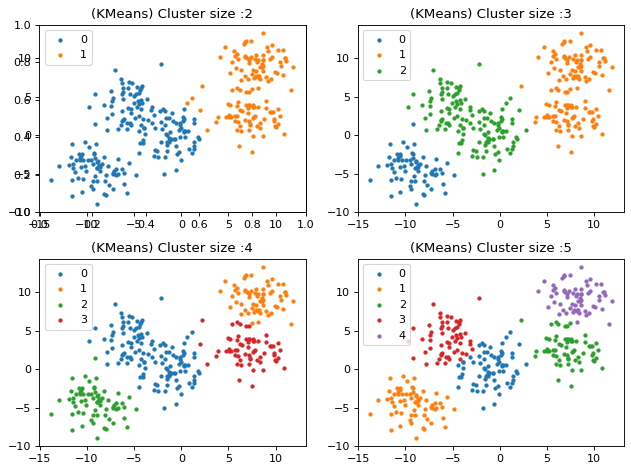

In [7]:
fig = plt.figure(figsize=(8,6),dpi=80)
fig.add_subplot(2,2,1)

for i in range(2,6):
    km=KMeans(n_clusters=i).fit(x)
    pred=km.predict(x)
    df=DataFrame({'x':x[:,0],'y':x[:,1],'label':pred})
    groups=df.groupby('label')
    fig.add_subplot(2,2,i-1)
    for name,group in groups:
        plt.scatter(group.x,group.y,label=name,s=8)
        plt.title("(KMeans) Cluster size :" + str(i))
        plt.legend()

plt.tight_layout()
plt.show()

# 2. Xây dựng thuật toán Mahalanobis Kmeans

## Import thư viện 

In [8]:
import numpy as np
from scipy.spatial.distance import mahalanobis

## Khởi tạo centroid và cluster tương ứng

Do hàm mahalanobis kmean sử dụng khoảng cách mahalanobis, mà khoảng cách mahalanobis sử dụng ma trận hiệp phương sai của các điểm dữ liệu trong cụm, nên khi khởi tạo ta không chỉ khởi tạo mỗi centroid như hàm kmean thông thường (sử dụng khoảng cách euclide) mà phải gán cluster tương ứng cho mỗi điểm dữ liệu

Có nhiều cách khởi tạo centroid và cluster , ví dụ như có thể khởi tạo ngẫu nhiên , tuy nhiên việc khởi tạo ngẫu nhiên không được hiệu quả cao 

Một cách khác là sử dụng thuật toán kmeans thông thường (sử dụng khoảng cách euclide) ở bước khởi tạo đầu tiên, trong bài nào em sẽ dùng cách này

## Khởi tạo centroids và cluster bằng kmeans thông thường 

In [9]:
def initiate_centroids_clusters(k,dset):
    km=KMeans(n_clusters=k,max_iter=1,random_state=234)
    # Lấy iter = 1 , nghĩa là chỉ khởi tạo bước lặp đầu tiên bằng thuật toán kmeans
    km.fit(dset)
    clusters=km.labels_
    centroids=DataFrame(km.cluster_centers_,columns=km.feature_names_in_)
    return clusters, centroids

## Hàm tính error, sử dụng khoảng cách mahalanobis

In [10]:
def mahalanobis_error(a,b,VI):
    # VI : Nghịch đảo của ma trận hiệp phương sai
    return mahalanobis(a,b,VI)

## Hàm gán centroid

In [11]:
def centroid_assignation(dset, centroids):
    # Số  centroid
    k = centroids.shape[0]

    # Số samples trong tập dữ liệu
    n = dset.shape[0]

    assignation = []

    assign_errors = []

    VI=[]
    
    # Tính ma trận hiệp phương sai cho từng cụm
    for centroid in range(k):
        VI.append(np.linalg.inv(np.cov(dset.loc[dset['centroid']==centroid,['x','y']],rowvar=False)))
    for obs in range(n):
        # List error cho từng centroid
        all_errors = np.array([])

        # Tính error cho từng centroid
        for centroid in range(k):
            err = mahalanobis_error(centroids.iloc[centroid,:], dset.iloc[obs, :2],VI[centroid])
            all_errors = np.append(all_errors, err)
        # Chọn centroid gần nhất 
        nearest_centroid = np.where(all_errors == np.amin(all_errors))[0].tolist()[0]
        nearest_centroid_error = np.amin(all_errors)

        assignation.append(nearest_centroid)
        assign_errors.append(nearest_centroid_error)

    return assignation, assign_errors


## Hàm vẽ cluster

In [12]:
def plot_cluster(df, centroids):
    # Số centroid
    k = centroids.shape[0]

    # Tạo figure và axes cho đồ thị
    fig, ax = plt.subplots(figsize=(8, 6))

    # Vẽ các quan sát và gán nhãn màu sắc dựa trên centroid
    plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=df['centroid'].astype('category'))
    

    # Vẽ các centroid
    scatter = plt.scatter(centroids.iloc[:, 0], centroids.iloc[:, 1], marker='s', s=200, c=[i for i in range(k)])

    ax.set_xlabel(r'x', fontsize=14)
    ax.set_ylabel(r'y', fontsize=14)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Tạo chú thích cho các centroid
    legend_labels = [f'centroid {i} : ({centroids.iloc[i, 0]:.2f}, {centroids.iloc[i, 1]:.2f})' for i in range(k)]
    plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='centroids')

    # Trả về axes để có thể thực hiện các tác vụ khác trên đồ thị
    return ax


## Hàm thuật toán chính ``mahalanobis_kmeans``

In [13]:
def mahalanobis_kmeans(dset, k=2, tol=1e-4,show_plot=True):
    # Tạo bản sao để tránh thay đổi data gốc
    working_dset = dset.copy()

    # Danh sách error cho từng bước lặp
    err = []

    # Biến điều kiện để tiếp tục vòng lặp
    goahead = True

    # Biến đếm số lần lặp
    j = 0
    
    # Gán giá trị khởi tạo cho centroids
    working_dset['centroid'],centroids=initiate_centroids_clusters(k,working_dset)
    while goahead:
        # Gán centroid và tính error cho các quan sát
        # working_dset['centroid'], j_err = centroid_assignation(working_dset.iloc[:, :2], centroids)
        working_dset['centroid'], j_err = centroid_assignation(working_dset, centroids)

        # Tính tổng error và vẽ đồ thị
        err.append(sum(j_err))
        if show_plot is True:
            ax = plot_cluster(working_dset, centroids)
            ax.set_title(f'Iteration {j}')
            plt.show()

        # Tính các centroid mới dựa trên các quan sát đã gán nhãn
        centroids = working_dset.groupby('centroid').agg('mean').reset_index(drop=True)

        if j > 0:
            if err[j-1] - err[j] <= tol:
                goahead = False

        j += 1

    return working_dset['centroid'], j_err, centroids


## Chạy hàm ``mahalanobis_kmeans``

c:\Users\votua\AppData\Local\Programs\Virtual Enviroment Python\ENV\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


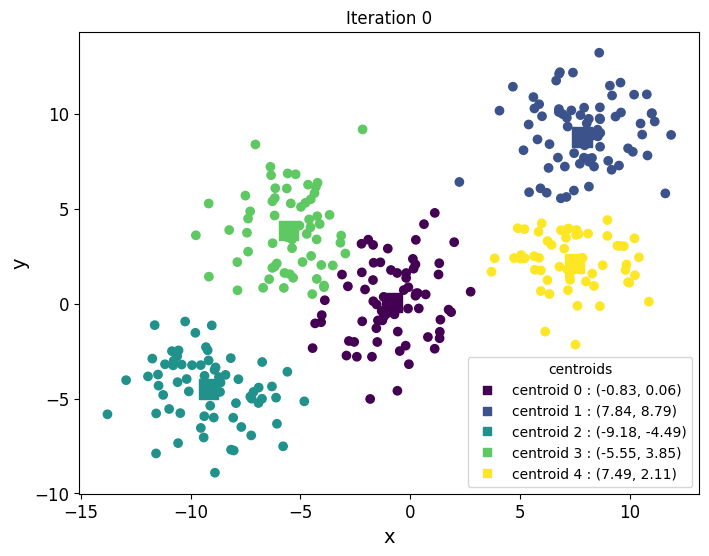

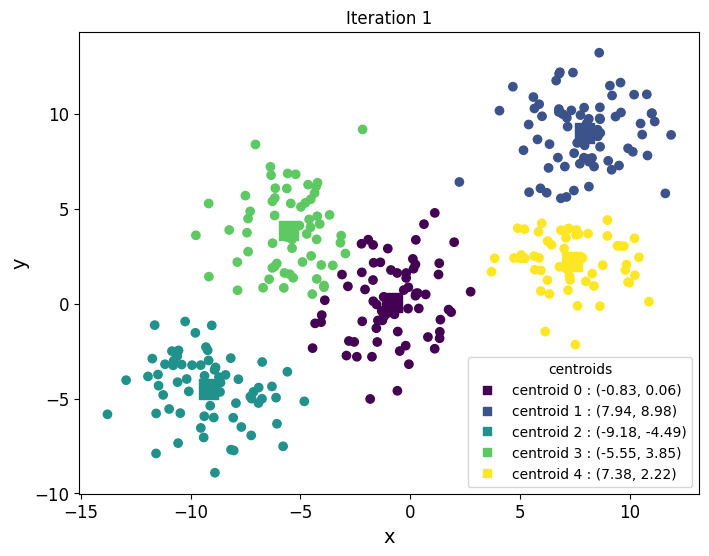

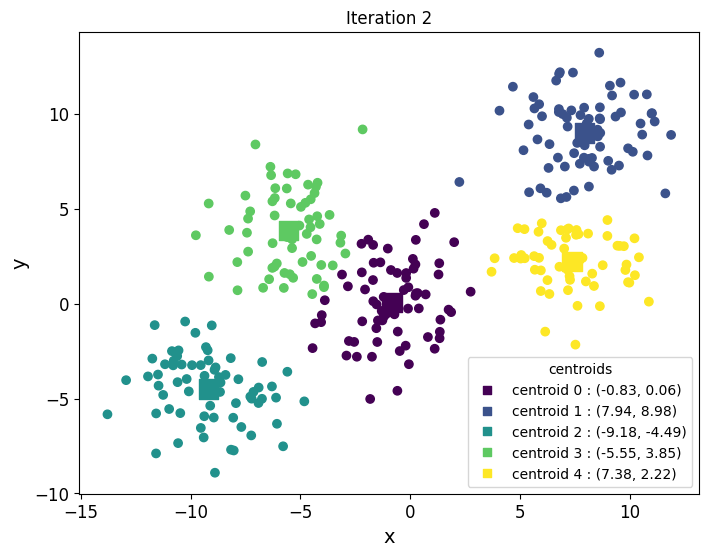

In [14]:
df=DataFrame({'x':x[:,0],'y':x[:,1]})
# np.random.seed(234)
df['centroid'],df['error'],centroids=mahalanobis_kmeans(df[['x','y']],k=5,show_plot=True,tol=1e-6)

Có thể thấy ``mahalanobis_kmeans`` và ``KMeans`` không có sự khác biệt trong trường hợp này, do dữ liệu này các cụm phân bố khá đồng đều và không bị correlated

## Tạo dữ liệu khác để so sánh 

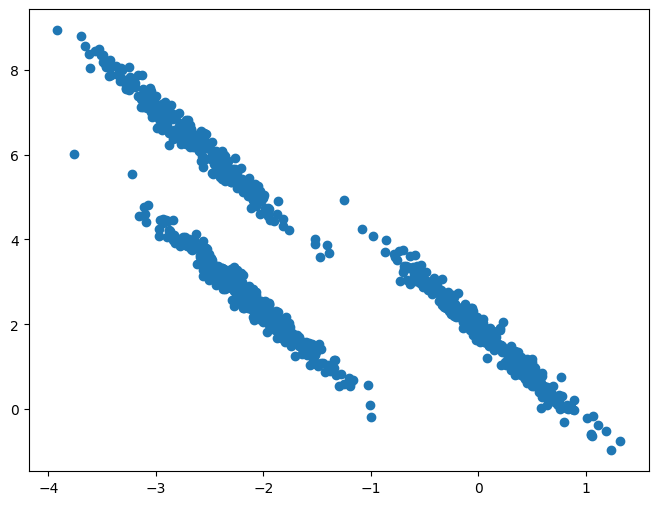

In [15]:
x, y = make_blobs(n_samples=1000, random_state=234,centers=3)
x = np.dot(x, [[0.2, -0.6], [-0.4, 0.8]])
plt.figure(figsize=(8,6))
plt.scatter(x[:,0],x[:,1])
plt.show()

## Sử dụng ``Kmeans`` thông thường 

c:\Users\votua\AppData\Local\Programs\Virtual Enviroment Python\ENV\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


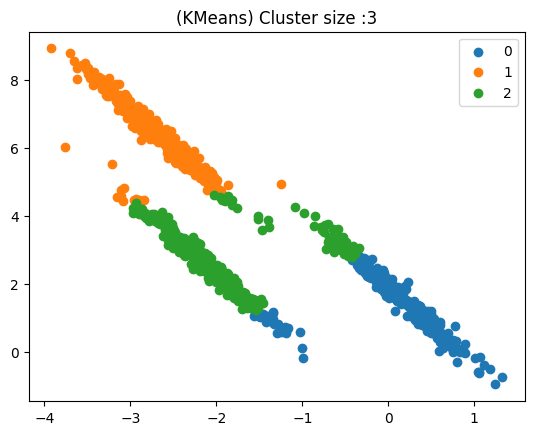

In [16]:
km=KMeans(n_clusters=3).fit(x)
pred=km.predict(x)
df=DataFrame({'x':x[:,0],'y':x[:,1],'label':pred})
groups=df.groupby('label')
for name,group in groups:
    plt.scatter(group.x,group.y,label=name)
    plt.title("(KMeans) Cluster size :" + str(3))
    plt.legend()

plt.show()

Có thể thấy thuật toán Kmeans thông thường phân cụm khá tệ trong trường hợp này

## Sử dụng ``mahalanobis_kmeans``

c:\Users\votua\AppData\Local\Programs\Virtual Enviroment Python\ENV\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


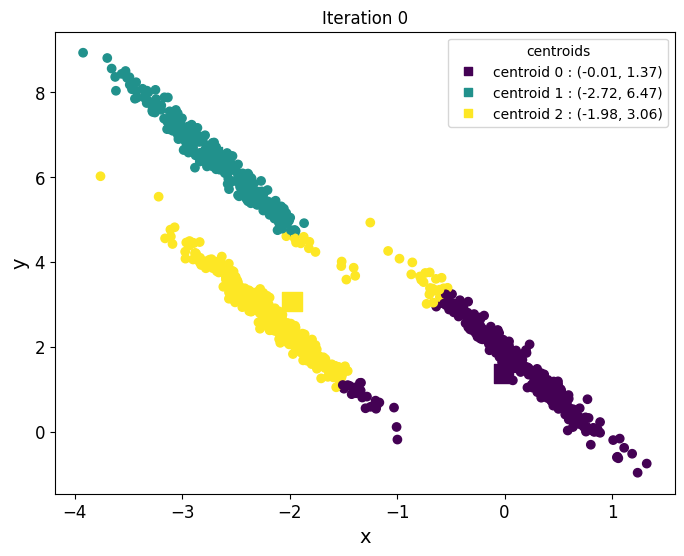

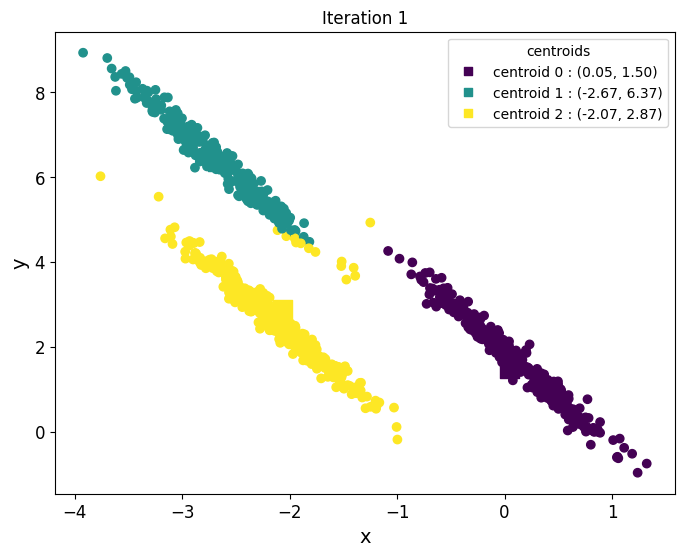

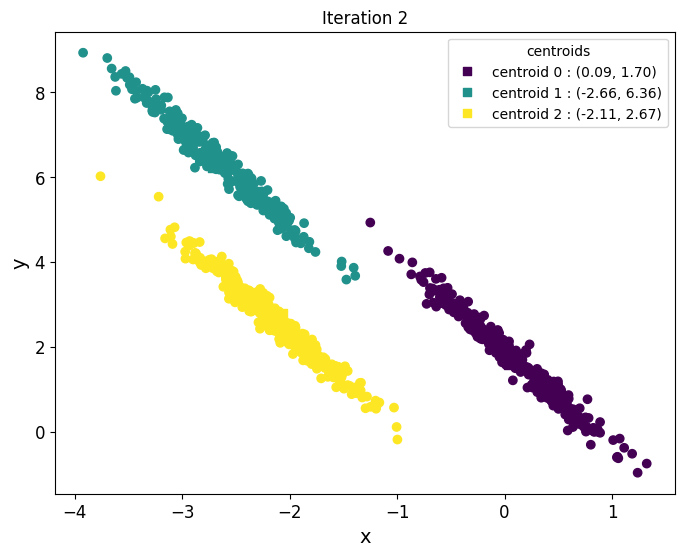

In [17]:
df=DataFrame({'x':x[:,0],'y':x[:,1]})
df['centroid'],df['error'],centroids=mahalanobis_kmeans(df[['x','y']],k=3,show_plot=True,tol=1e-6)

Có thể thấy trong trường hợp này, ``mahalanobis_kmeans`` phân cụm tốt hơn rất nhiều so với ``KMeans`` bình thường 

## Thử thêm với ``GMM``

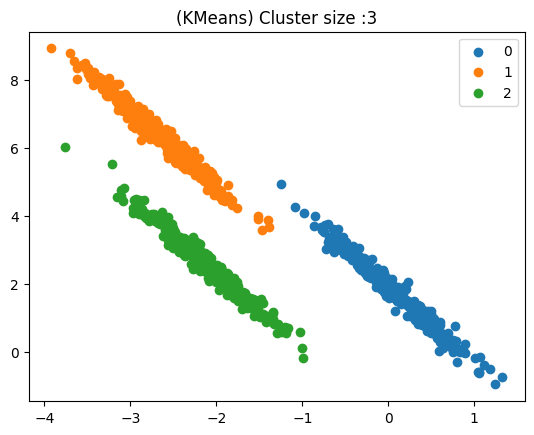

In [18]:
gm=GaussianMixture(n_components=3).fit(x)
pred=gm.predict(x)
df=DataFrame({'x':x[:,0],'y':x[:,1],'label':pred})
groups=df.groupby('label')
for name,group in groups:
    plt.scatter(group.x,group.y,label=name)
    plt.title("(KMeans) Cluster size :" + str(3))
    plt.legend()

plt.show()

``GMM`` có kết quả tương tự với ``mahalanobis_kmeans``